#### ANN (Activity 09)
- Check the repo in https://github.com/helonayala/narx_narendra 
- Read about the system analyzed in this code, as given in the paper by Narendra in [2] (Section V, Example 4, p. 16)
- Check the input-output data for the estimation/validation phase as described in the paper (Fig. 16) which is implemented in this code
- Inspect that the data is scaled in the range [0,1]
- Run and build the models with the code provided using tensorflow considering ny = 3, nu = 2
- Evaluate the free-run simulation in validation phase to validate the models
- Now re-do all the steps using the robot arm data you have used in the past activities. The deliverable should be the notebook with your comments and results

In [176]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from scipy import signal

import pandas as pd
import pickle
import seaborn as sns

# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
tf.random.set_seed(rseed)
# print precision
np.set_printoptions(precision=3)


#### Useful functions

Let us define matreg and freerun

In [76]:
def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    (N, ) = y.shape
    (Nu, ) = u.shape
    
    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)
    
    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1 
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)
        
        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input, verbose=0)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):] 


#### Robot arm data import

Reading data from the robot arm.... Data already normalized [-1,1]

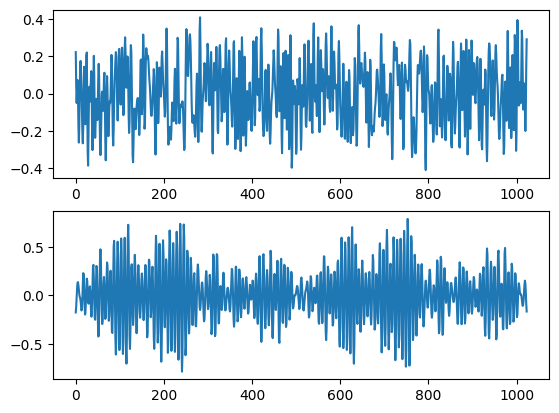

In [5]:
data = np.loadtxt('robot_arm.dat')

U=data[:,0]
Y=data[:,1]

f,ax = plt.subplots(2)
ax[0].plot(U)
ax[1].plot(Y)
pass;

#### Preparing data

Splittng data the same way as previsously (70%/30% for parameters estimation/validation)

In [120]:
p_train = 0.7

split_n = int(p_train*len(U))
ue = U[:split_n]
ye = Y[:split_n]
ut = U[split_n:]
yt = Y[split_n:]

Plotting

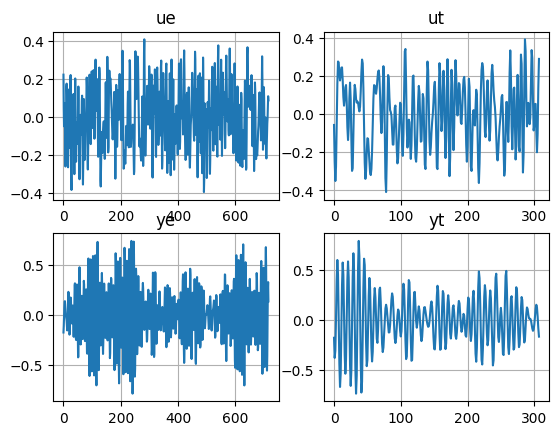

In [122]:
plt.figure()
plt.subplot(221)
plt.plot(ue)
plt.title('ue')
plt.grid()
plt.subplot(222)
plt.plot(ut)
plt.title('ut')
plt.grid()
plt.subplot(223)
plt.plot(ye)
plt.title('ye')
plt.grid()
plt.subplot(224)
plt.plot(yt)
plt.title('yt')
plt.grid()
plt.show()


#### ANN Modelling

Early Stopping because the validation loss is increasing after a certain epoch and we wish to optimiza params

In [177]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

Main loop over model order and ann paramters

In [212]:
dict = {
    'order': [],
    'nneurons': [],
    'hidden_layers': [],
    'R2_OS': [],
    'R2_FS': [],
}

best_r2 = -200

orders = [2,3,4,6,8,10]
nneurons = [5,10,20,40,80]
hidden_layers = [1,2,3]

nout = 1

print(f'o', end=' ')
print(f'nn', end=' ')
print(f'hl', end=' ')
print(f'R2trOSA', end=' ')
print(f'R2teOSA', end=' ')
print(f'R2teFS')

for o in orders:    
    for nneu in nneurons:
        for hidden_layer in hidden_layers:
            print(f'{o}', end=' ')
            print(f'{nneu}', end=' ')
            print(f'{hidden_layer}', end=' ')
            
            ny = o
            nu = o # model orders
            (Ye,Phie) = matReg(ye,ue,ny,nu)
            (Yt,Phit) = matReg(yt,ut,ny,nu)

            ninp = Phie.shape[1]

            # model definition
            input_ = keras.layers.Input(shape=(ninp,))
            hidden1 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal",)(input_)
            hidden2 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden1)
            hidden3 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden2)

            # vary number of hidden lauers
            if hidden_layer == 1:
                hidden = hidden1
            elif hidden_layer == 2:
                hidden = hidden2
            else:
                hidden = hidden3
            output = keras.layers.Dense(nout)(hidden)

            # instantiate model
            model = keras.models.Model(inputs=[input_],outputs=[output])

            # define optimizer and learning rate
            optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

            # compile model to train it
            model.compile(loss="mean_squared_error", optimizer=optimizer)

            # train model
            history = model.fit(Phie, Ye, epochs=50, batch_size = 32, callbacks=[earlyStop], verbose=0)

            # One step ahead
            y_train_pred1 = model.predict(Phie,verbose=0)
            y_test_pred1  = model.predict(Phit,verbose=0)
            R2test1  = r2_score(Yt, y_test_pred1)
            R2train1 = r2_score(Ye, y_train_pred1)

            # Free Run
            y_test_pred0  = freeRun(model,yt,ut,ny,nu)
            R2test0  = r2_score(Yt, y_test_pred0)

            print(f'\t{R2train1:.2f}', end=' ')
            print(f'\t{R2test1:.2f}', end=' ')
            print(f'\t{R2test0:.2f}', end=' ')

            dict['order'].append(o)
            dict['nneurons'].append(nneu)
            dict['hidden_layers'].append(hidden_layer)
            dict['R2_OS'].append(R2test1)
            dict['R2_FS'].append(R2test0)

            #saving best model
            if R2test0 > best_r2:
                best_model = model
                best_r2 = R2test0
                print ('\t(best so far)', end=' ')
            
            print()
            

o nn hl R2trOSA R2teOSA R2teFS
2 5 1 	0.99 	0.99 	-0.03 	(best so far) 
2 5 2 	0.98 	0.98 	0.06 	(best so far) 
2 5 3 	0.99 	0.98 	0.41 	(best so far) 
2 10 1 	0.98 	0.97 	-0.66 
2 10 2 	0.99 	0.99 	-0.37 
2 10 3 	0.99 	0.99 	0.01 
2 20 1 	0.98 	0.98 	0.01 
2 20 2 	0.99 	0.99 	-0.74 
2 20 3 	0.99 	0.99 	-0.72 
2 40 1 	0.98 	0.98 	-0.09 
2 40 2 	0.99 	0.99 	-0.15 
2 40 3 	0.99 	0.98 	-2.22 
2 80 1 	0.99 	0.99 	-0.65 
2 80 2 	0.99 	0.99 	-1.27 
2 80 3 	0.96 	0.95 	-2.19 
3 5 1 	0.96 	0.96 	-0.00 
3 5 2 	0.96 	0.95 	-0.07 
3 5 3 	0.96 	0.94 	0.07 
3 10 1 	0.99 	0.98 	0.39 
3 10 2 	0.99 	0.99 	-0.25 
3 10 3 	0.99 	0.99 	0.19 
3 20 1 	0.98 	0.98 	0.27 
3 20 2 	0.99 	0.99 	-0.02 
3 20 3 	0.99 	0.98 	-1.52 
3 40 1 	0.99 	0.99 	-1.25 
3 40 2 	1.00 	0.99 	0.43 	(best so far) 
3 40 3 	0.99 	0.99 	-0.39 
3 80 1 	1.00 	0.99 	0.11 
3 80 2 	0.99 	0.99 	-1.50 
3 80 3 	0.99 	0.98 	-0.24 
4 5 1 	0.90 	0.87 	0.25 
4 5 2 	0.95 	0.94 	0.27 
4 5 3 	0.96 	0.95 	0.27 
4 10 1 	0.97 	0.96 	0.41 
4 10 2 	0.98 	

Saving dict in order to avoid training again

In [213]:
pickle.dump(dict, open('dict.p', 'wb'))

Results

In [232]:
df = pd.DataFrame(dict)
df = df[df['R2_FS'] > -1] #filtering worst models
df.sort_values('R2_FS', ascending=False).head(5)

,order,nneurons,hidden_layers,R2_OS,R2_FS
76,10,5,2,0.988860,0.897210
75,10,5,1,0.986988,0.869343
48,6,10,1,0.978513,0.869079
79,10,10,2,0.991956,0.857424
64,8,10,2,0.995007,0.778218


Plotting Results (sensibility to the ANN architecture parameters)

<AxesSubplot: xlabel='hidden_layers', ylabel='R2_FS'>

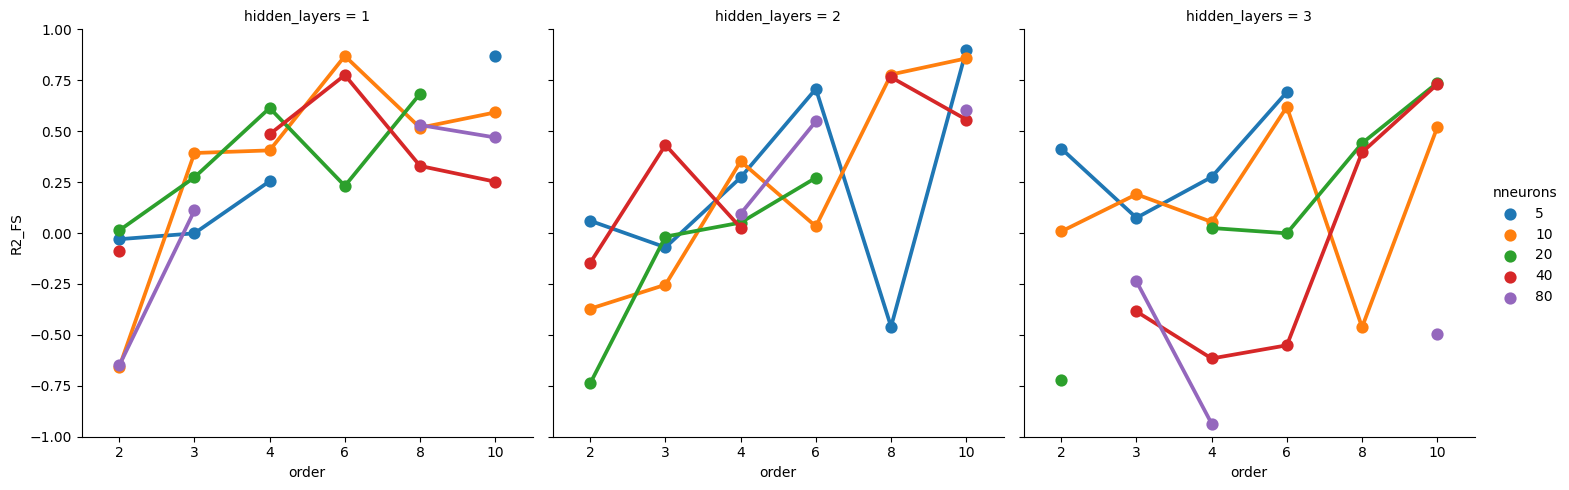

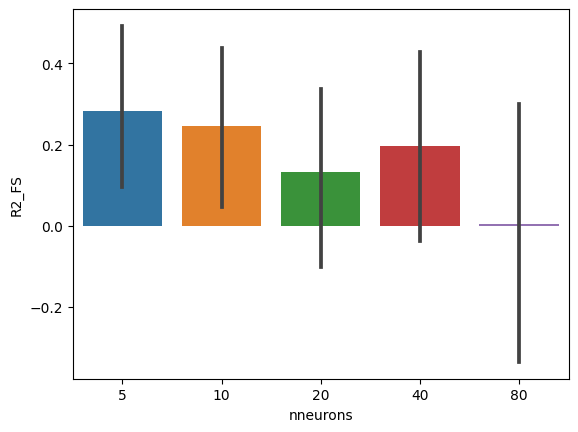

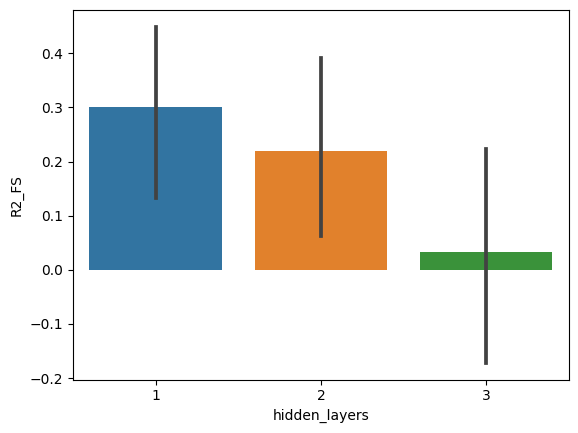

In [231]:
sns.catplot(data=df, col='hidden_layers', hue = 'nneurons', y='R2_FS', x='order', kind='point')
plt.ylim([-1,1])
plt.figure()
sns.barplot(data=df, x='nneurons', y='R2_FS')
plt.figure()
sns.barplot(data=df, x='hidden_layers', y='R2_FS')

Concluding Remarks:
> - In general, higher order (na, nb) increases performance
> - Models perform better in lower neurons and less hidden layers 
> - The best combination of these parameters in terms of Free Simulation $R^2$ was achieved with order=$10$, $5$ hidden neurons and $2$ hidden layers ($R^2=0.90$)
> - In some cases, the training metrics (validation loss) started to increase after a certain number of epochs. In order to stop the training when the loss starts increasing for 5 consecutive epochs, an early stop procedure was implemented:      
>       `earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)`
> - Other parameters like `learning rate` and `hidden activation function` could be optimized, but we considered that the $R^2$ is ok although the polynomial NARMAX got better results.
> - *Important Remark:* A neural network is a stochastic method, as the value of it's trained weights are subject to the initialization. A good practice is to have it's result as an average of some realizations, for the same architecture.

Plot predictions

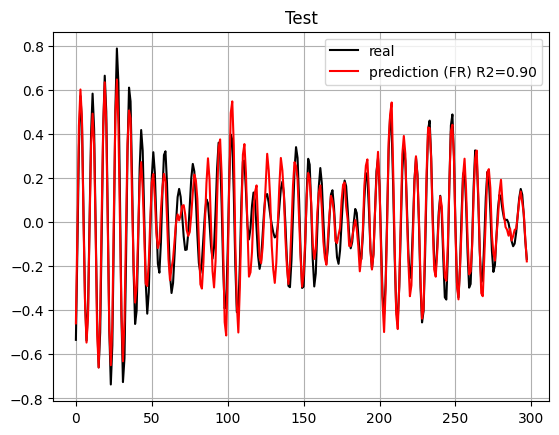

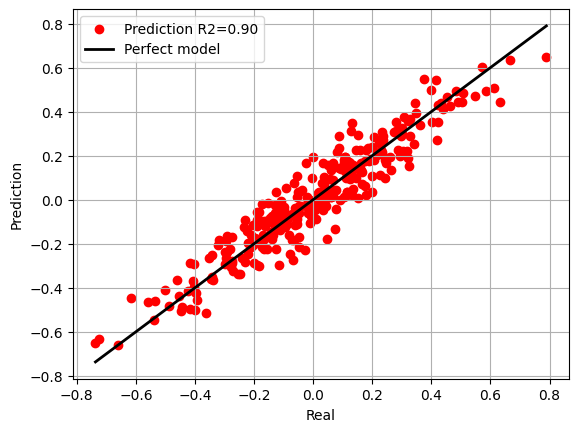

In [227]:
y_test_pred0  = freeRun(best_model,yt,ut,ny,nu)
R2test0  = r2_score(Yt, y_test_pred0)

plt.figure()
plt.plot(Yt,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real',f'prediction (FR) R2={R2test0:.2f}'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt),min(y_test_pred0))
maxY = max(max(Yt),max(y_test_pred0))
plt.scatter(Yt,y_test_pred0,c='red',label=f'Prediction R2={R2test0:.2f}')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()